In [10]:
import numpy as np
from data_scripts import load_data as load_data
from thermal_solvers import make_thermal_solver_space
from matplotlib import pyplot as plt

N_NEWEST = 1


def only_cpr(path):
    data = load_data(path, n_newest=N_NEWEST)
    results = []
    for sim in data:
        results.extend(
            [val for val in sim if "schur_cd" in val.config["gmres"]["preconditioner"]]
        )
    return results

np.random.seed(42)

# data_m = only_cpr("examples/2/thermal_warmstart_m_s_stacking.py")
# data_m = only_cpr("examples/2/thermal_warmstart_m_s_stacking")
data_l = only_cpr('examples/2/thermal_warmstart_l_sm_stacking')

Loading data:
/home/firedrake/solver_selector/examples/2/performance/thermal_warmstart_l_sm_stacking_7.npy


In [11]:
from data_scripts import get_newest_data_paths
from solver_selector.performance_predictor import make_performance_predictor, train_performance_predictor
from thermal_solvers import make_thermal_solver_space

cpr_template = make_thermal_solver_space(solver='schur').get_all_solvers()[0]

In [12]:
def compare(div):
    # data_train, data_test = data_m[:div], data_m[div:]
    data_train, data_test = data_l[:div], data_l[div:]

    stacking = make_performance_predictor(
        params={
            "print_solver": True,
            "regressor": "stacking",
            "samples_before_fit": 0,
            "stacking_datasets": [
                get_newest_data_paths("examples/1/thermal_dynamic", n_newest=1),
                get_newest_data_paths("examples/2/thermal_warmstart_m_s_stacking", n_newest=1),
            ],
        },
        solver_template=cpr_template,
    )

    baseline = make_performance_predictor(
        params={
            "print_solver": True,
            "samples_before_fit": 0,
        },
        solver_template=cpr_template,
    )
    train_performance_predictor(
        baseline,
        data_paths=(
            get_newest_data_paths("examples/1/thermal_dynamic", n_newest=1)
            + get_newest_data_paths("examples/2/thermal_warmstart_m_s_stacking", n_newest=1)
        ),
    )

    stacking.offline_update(data_train)
    baseline.offline_update(data_train)

    full_contexts_list = []
    rewards_list = []
    for selection_data in data_test:
        full_context, rewards = baseline._prepare_fit_data(selection_data)
        full_contexts_list.append(full_context)
        rewards_list.append(rewards)
    full_contexts = np.concatenate(full_contexts_list)
    rewards = np.concatenate(rewards_list)

    baseline_score = baseline.regressor.score(full_contexts, rewards)
    stacking_score = stacking.regressor.score(full_contexts, rewards)
    coefs = list(stacking.regressor.trust_model.coef_) + [
        stacking.regressor.trust_model.intercept_
    ]
    return baseline_score, stacking_score, coefs

In [13]:
from tqdm import tqdm

b_list = []
s_list = []
c_list = []
x_list = np.arange(5, 20)
for i in tqdm(x_list):
    baseline, stacking, coefs = compare(div=i)
    b_list.append(baseline)
    s_list.append(stacking)
    c_list.append(coefs)


  0%|          | 0/15 [00:00<?, ?it/s]

Using epsilon-greedy exploration
Using regressor: stacking
Building base predictor 0 with data:
/home/firedrake/solver_selector/examples/1/performance/thermal_dynamic_33.npy
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Building base predictor 1 with data:
/home/firedrake/solver_selector/examples/2/performance/thermal_warmstart_m_s_stacking_10.npy
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting


  7%|▋         | 1/15 [01:52<26:16, 112.59s/it]

Using epsilon-greedy exploration
Using regressor: stacking
Building base predictor 0 with data:
/home/firedrake/solver_selector/examples/1/performance/thermal_dynamic_33.npy
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Building base predictor 1 with data:
/home/firedrake/solver_selector/examples/2/performance/thermal_warmstart_m_s_stacking_10.npy
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting


 13%|█▎        | 2/15 [01:53<10:11, 47.07s/it] 

Using epsilon-greedy exploration
Using regressor: stacking
Building base predictor 0 with data:
/home/firedrake/solver_selector/examples/1/performance/thermal_dynamic_33.npy
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Building base predictor 1 with data:
/home/firedrake/solver_selector/examples/2/performance/thermal_warmstart_m_s_stacking_10.npy
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting


 20%|██        | 3/15 [01:55<05:13, 26.14s/it]

Using epsilon-greedy exploration
Using regressor: stacking
Building base predictor 0 with data:
/home/firedrake/solver_selector/examples/1/performance/thermal_dynamic_33.npy
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Building base predictor 1 with data:
/home/firedrake/solver_selector/examples/2/performance/thermal_warmstart_m_s_stacking_10.npy
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting


 27%|██▋       | 4/15 [01:56<02:59, 16.29s/it]

Using epsilon-greedy exploration
Using regressor: stacking
Building base predictor 0 with data:
/home/firedrake/solver_selector/examples/1/performance/thermal_dynamic_33.npy
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Building base predictor 1 with data:
/home/firedrake/solver_selector/examples/2/performance/thermal_warmstart_m_s_stacking_10.npy
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting


 33%|███▎      | 5/15 [01:57<01:48, 10.89s/it]

Using epsilon-greedy exploration
Using regressor: stacking
Building base predictor 0 with data:
/home/firedrake/solver_selector/examples/1/performance/thermal_dynamic_33.npy
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Building base predictor 1 with data:
/home/firedrake/solver_selector/examples/2/performance/thermal_warmstart_m_s_stacking_10.npy
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting


 40%|████      | 6/15 [01:58<01:08,  7.60s/it]

Using epsilon-greedy exploration
Using regressor: stacking
Building base predictor 0 with data:
/home/firedrake/solver_selector/examples/1/performance/thermal_dynamic_33.npy
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Building base predictor 1 with data:
/home/firedrake/solver_selector/examples/2/performance/thermal_warmstart_m_s_stacking_10.npy
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting


 47%|████▋     | 7/15 [02:00<00:44,  5.55s/it]

Using epsilon-greedy exploration
Using regressor: stacking
Building base predictor 0 with data:
/home/firedrake/solver_selector/examples/1/performance/thermal_dynamic_33.npy
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Building base predictor 1 with data:
/home/firedrake/solver_selector/examples/2/performance/thermal_warmstart_m_s_stacking_10.npy
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting


 53%|█████▎    | 8/15 [02:01<00:29,  4.17s/it]

Using epsilon-greedy exploration
Using regressor: stacking
Building base predictor 0 with data:
/home/firedrake/solver_selector/examples/1/performance/thermal_dynamic_33.npy
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Building base predictor 1 with data:
/home/firedrake/solver_selector/examples/2/performance/thermal_warmstart_m_s_stacking_10.npy
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting


 53%|█████▎    | 8/15 [02:01<01:46, 15.25s/it]


KeyboardInterrupt: 

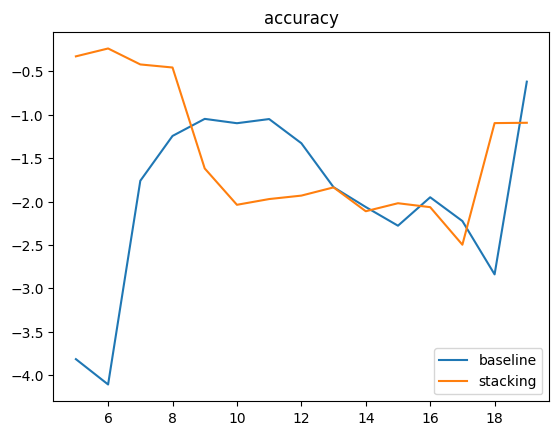

In [5]:
plt.plot(x_list, b_list, label="baseline")
plt.plot(x_list, s_list, label="stacking")
plt.title("accuracy")
# plt.ylim(0, 1)
plt.legend()

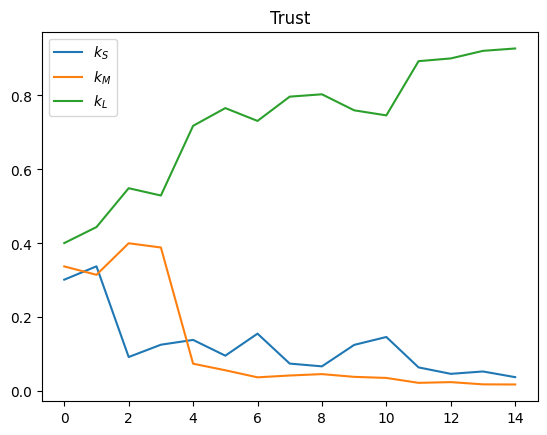

In [7]:
plt.plot(np.array(c_list)[:, 0], label="$k_S$")
plt.plot(np.array(c_list)[:, 1], label="$k_M$")
plt.plot(np.array(c_list)[:, 2], label="$k_L$")
# plt.plot(np.array(c_list)[:, 3], label='$b$')
plt.title("Trust")
# plt.yscale('log')
plt.legend()